In [12]:
import sys
sys.path.append("..")


from experiments.plt_pab_fae import plt_fab_fae
from protocol.BB84EveTrainableProtocol import BB84EveTrainableProtocol
from protocol.BB84TrainableProtocol import BB84TrainableProtocol
from protocol.connection_elements.Layer import SeparableLayer, EntangledLayer
from protocol.BB84Protocol import BB84Protocol
from protocol.connection_elements.MultiQubitQCLEve import MultiQubitQCLEve


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


cuda
cuda:0
cuda
cuda:0


/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/qiskit/circuit/quantumcircuit.py:3428: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


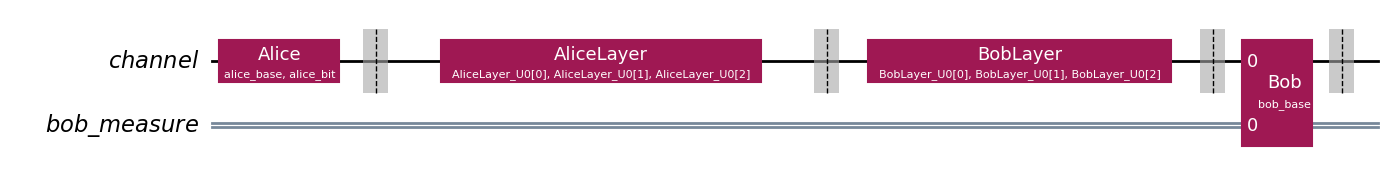

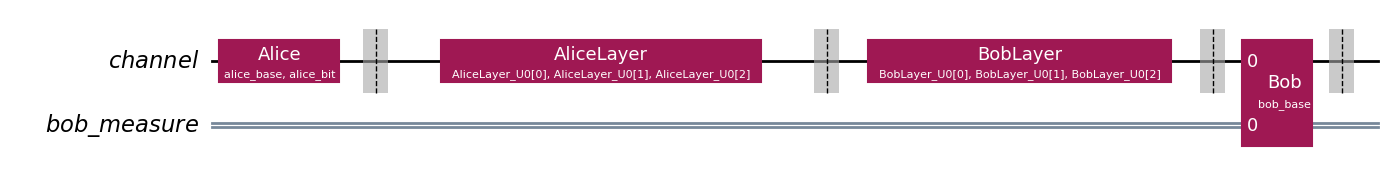

In [13]:
layers = [SeparableLayer("AliceLayer"), SeparableLayer("BobLayer")]
eve = MultiQubitQCLEve()

ab_protocol = BB84TrainableProtocol(n_bits=512, elements=layers, channel_size=1, seed=0, learning_rate=0.1, torch_device="cuda")
eve_protocol = BB84EveTrainableProtocol(n_bits=512, elements=[layers[0], eve, layers[1]], channel_size=1,
                                        seed=0, alpha=1, learning_rate=0.1, torch_device="cuda")

qc, _ = ab_protocol.qc_with_ctx()
qc.draw("mpl", expr_len=3)

In [14]:
def train_eve():
    bob_qber, eve_qber = [], []
    qber = eve_protocol.run()
    bob_qber.append(qber['bob_qber'])
    eve_qber.append(qber['eve_qber'])
    print(f'start QBER: {qber}')
    for epoch in range(50):
        loss = eve_protocol.train()
        qber = eve_protocol.run()
        bob_qber.append(qber['bob_qber'])
        eve_qber.append(qber['eve_qber'])
        if epoch % 5 == 0 or epoch == 49:
            print(f'epoch: {epoch}, loss: {loss}, QBER: {qber}')
    return bob_qber, eve_qber

def train_ab():
    bob_qber, eve_qber = [], []
    qber = ab_protocol.run()
    bob_qber.append(qber['bob_qber'])
    eve_qber.append(0.5)
    print(f'start QBER: {qber}')
    for epoch in range(20):
        loss = ab_protocol.train()
        qber = ab_protocol.run()
        bob_qber.append(qber['bob_qber'])
        eve_qber.append(0.5)
        if epoch % 5 == 0 or epoch == 19:
            print(f'epoch: {epoch}, loss: {loss}, QBER: {qber}')
    return bob_qber, eve_qber

# Krok 1 - trenowanie Alice i Boba do początkowego stanu
Uczymy Alice i Boba bez Eve, aby miały sensowne parametry początkowe i potrafiły przekazywać sobie dane.

In [15]:
b_q, e_q = train_ab()

start QBER: {'bob_qber': np.float64(0.4365079365079365)}
start
cuda:0
outputs
loss
tensor(-0.6081, device='cuda:0', grad_fn=<NegBackward0>)
backward
grad device: [device(type='cuda', index=0)]
step
epoch: 0, loss: -0.6081171035766602, QBER: {'bob_qber': np.float64(0.3373015873015873)}
start
cuda:0
outputs
loss
tensor(-0.7181, device='cuda:0', grad_fn=<NegBackward0>)
backward
grad device: [device(type='cuda', index=0)]
step
start
cuda:0
outputs
loss
tensor(-0.8122, device='cuda:0', grad_fn=<NegBackward0>)
backward
grad device: [device(type='cuda', index=0)]
step
start
cuda:0
outputs
loss
tensor(-0.8872, device='cuda:0', grad_fn=<NegBackward0>)
backward
grad device: [device(type='cuda', index=0)]
step
start
cuda:0
outputs
loss
tensor(-0.9345, device='cuda:0', grad_fn=<NegBackward0>)
backward
grad device: [device(type='cuda', index=0)]
step
start
cuda:0
outputs
loss
tensor(-0.9714, device='cuda:0', grad_fn=<NegBackward0>)
backward
grad device: [device(type='cuda', index=0)]
step
epoch: 5,

<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

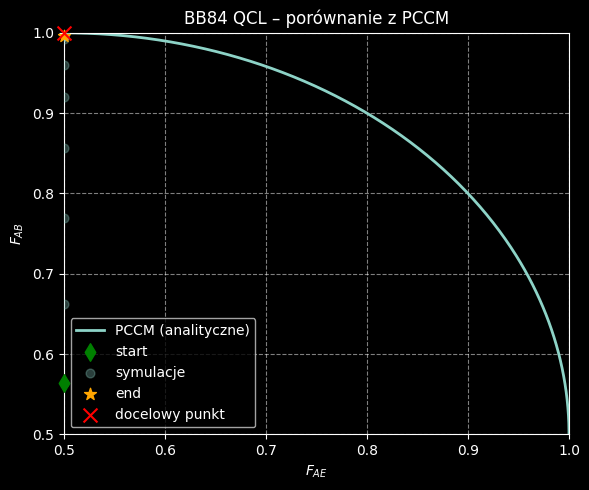

In [16]:
plt_fab_fae(b_q, e_q, 1)

# Krok 2 - trenowanie tylko Eve, warstwy Alice i Boba zamrożone
Uczymy samą Eve, docelowa dokładność Boba to 0.8. Startujemy od parametrów Alice i Boba wytrenowanych w poprzednim kroku i Eve jako identyczność.

In [17]:
eve_protocol.set_parameters(ab_protocol.get_all_parameters())

params = eve_protocol.get_all_parameters()
for p in eve.trainable_parameters():
    k = p.name
    params[k] = 0

eve_protocol.set_parameters(params)
eve_protocol.freeze_elements(layers)
print("Trainable parameters:", eve_protocol.get_unfrozen_parameters())
print("Frozen parameters:", eve_protocol.get_frozen_params())


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/qiskit_machine_learning/connectors/torch_connector.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights.data = torch.tensor(initial_weights, dtype=torch.float)
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Trainable parameters: {'NU_W_U0[0]': np.float32(0.0), 'NU_W_U0[1]': np.float32(0.0), 'NU_W_U0[2]': np.float32(0.0), 'NU_W_U1[0]': np.float32(0.0), 'NU_W_U1[1]': np.float32(0.0), 'NU_W_U1[2]': np.float32(0.0), 'NU_W_weyl[0]': np.float32(0.0), 'NU_W_weyl[1]': np.float32(0.0), 'NU_W_weyl[2]': np.float32(0.0), 'ΛZ[0]': np.float32(0.0), 'ΛZ[1]': np.float32(0.0), 'ΛZ[2]': np.float32(0.0), 'ΛX[0]': np.float32(0.0), 'ΛX[1]': np.float32(0.0), 'ΛX[2]': np.float32(0.0)}
Frozen parameters: {'AliceLayer_U0[0]': np.float32(-0.30262637), 'AliceLayer_U0[1]': np.float32(2.1431103), 'AliceLayer_U0[2]': np.float32(-1.4428211), 'BobLayer_U0[0]': np.float32(-0.29461253), 'BobLayer_U0[1]': np.float32(-2.0418925), 'BobLayer_U0[2]': np.float32(1.3339852)}


In [ ]:
eve_protocol.f_value = 0.8
b_q, e_q = train_eve()

start QBER: {'bob_qber': np.float64(0.007352941176470562), 'eve_qber': np.float64(0.5294117647058824)}
start
cuda:0
outputs
loss
tensor(-1.0001, device='cuda:0', grad_fn=<AddBackward0>)
backward
grad device: [device(type='cuda', index=0)]
step
epoch: 0, loss: -1.0001168251037598, QBER: {'bob_qber': np.float64(0.02573529411764708), 'eve_qber': np.float64(0.5257352941176471)}
start
cuda:0
outputs
loss
tensor(-0.9698, device='cuda:0', grad_fn=<AddBackward0>)
backward
grad device: [device(type='cuda', index=0)]
step
start
cuda:0
outputs
loss
tensor(-1.0193, device='cuda:0', grad_fn=<AddBackward0>)
backward
grad device: [device(type='cuda', index=0)]
step
start
cuda:0
outputs
loss
tensor(-0.9962, device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
plt_fab_fae(b_q, e_q, 0.8)

# Krok 3 - trenowanie warstw Alice i Boba, Eve zamrożona
Próbujemy uczyć Alice i Boba z użyciem nowej funkcji straty, która maksymalizuje jedynie dokładność Boba.

In [ ]:
eve_protocol.freeze_elements([eve])
print("Trainable parameters:", eve_protocol.get_unfrozen_parameters())
print("Frozen parameters:", eve_protocol.get_frozen_params())

In [ ]:
eve_loss = eve_protocol.loss
eve_protocol.loss = ab_protocol.loss
b_q, e_q = train_eve()

In [ ]:
plt_fab_fae(b_q, e_q, 1)

In [ ]:
eve_protocol.freeze_elements(layers)
print("Trainable parameters:", eve_protocol.get_unfrozen_parameters())
print("Frozen parameters:", eve_protocol.get_frozen_params())

In [ ]:
eve_protocol.f_value = 0.8
eve_protocol.loss = eve_loss
b_q, e_q = train_eve()

In [ ]:
plt_fab_fae(b_q, e_q, 0.8)

In [ ]:
eve_protocol.freeze_elements([eve])
print("Trainable parameters:", eve_protocol.get_unfrozen_parameters())
print("Frozen parameters:", eve_protocol.get_frozen_params())

In [ ]:
eve_protocol.loss = ab_protocol.loss
b_q, e_q = train_eve()

In [ ]:
plt_fab_fae(b_q, e_q, 1)

In [ ]:
print("All parameters:", eve_protocol.get_all_parameters())

In [ ]:
eve_protocol._qc.assign_parameters(eve_protocol.get_all_parameters()).draw("mpl")